In [7]:
#%matplotlib notebook
import os
import sys
sys.path.append("numpy_path")
import numpy as np
import struct
from matplotlib import pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import RMSprop
import keras.callbacks as cb
from keras.callbacks import EarlyStopping, ModelCheckpoint
from math import cos, sin, pi
import math
from statistics import mean
import os.path

shape_size = 48

# define loss history
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)

#plot losses
def plot_losses(losses):
    plt.plot(losses)
    plt.title('Loss per batch')
    plt.show()

def feature_scaling(X):
    X = X.T
    for i in range(7):
        mean = X[i].mean()
        std = X[i].std()
        X[i] = [(x - mean)/std for x in X[i]]
    return X.T

# input dimension
dim = 200

def init_model():
    model = Sequential()
    model.add(Dense(80, input_dim=dim))
    model.add(Activation('relu'))
    model.add(Dense(80))
    model.add(Activation('relu'))
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dense(80))
    model.add(Activation('relu'))
    model.add(Dense(40))
    model.add(Activation('relu'))
    model.add(Dense(30))
    model.add(Activation('relu'))
    model.add(Dense(20))
    model.add(Activation('relu'))
    model.add(Dense(6))
    model.add(Activation('sigmoid'))
    # use mean squared error to measure the looses
    model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(lr = 0.001),
              metrics=['accuracy'])
    return model

In [8]:
data_size = 0
dummy1 = [0]*200
dummy2 = [0]*6
SP = np.array(np.reshape(dummy1, (1, 200)))
SH = np.array(np.reshape(dummy2, (1, 6)))
for i in range(2, 65):
    path = 'meep_code/data/DATA'+str(i)
    if not os.path.exists(path):
        #miss.append(i)
        print('Missing batch:' + str(i))
        continue
        
    files = next(os.walk(path))[2] #dir is your directory path as string]
    num_data = len(files)
    data_size += num_data
    skip = []
    
    coordinates = np.genfromtxt('meep_code/data/DATA'+str(i)+'_sh.txt')
    xc, yc = coordinates[:, 0], coordinates[:, 1]
    xc = np.reshape(xc, (num_data, shape_size))
    yc = np.reshape(yc, (num_data, shape_size))
    
    for j in range(num_data):
        tmp = np.genfromtxt(path+'/'+'DATA'+str(i)+'_sp'+str(j)+'.txt')
        valid = True
        for q in range(200):       
            if tmp[q] > 3:
                print('Batch '+str(i)+'\tsample '+str(j)+' has extreme value')
                valid = False
                break
        if not valid:
            #skip.append(j)
            continue
        SP = np.concatenate((SP, np.reshape(tmp, (1, 200))))
        tmp = []
        for q in range(6):
            tmp.append(math.sqrt(xc[j][q]**2 + yc[j][q]**2))
        SH = np.concatenate((SH, np.reshape(np.array(tmp), (1, 6))))
        #print(SP.shape)
    #print(files)
#     coordinates = np.genfromtxt('meep_code/data/DATA'+str(i)+'_sh.txt')
#     xc, yc = coordinates[:, 0], coordinates[:, 1]
#     xc = np.reshape(xc, (num_data, shape_size))
#     yc = np.reshape(yc, (num_data, shape_size))
#     for j in range(num_data):
#         if j in skip:
#             continue
#         tmp = []
#         for q in range(6):
#             tmp.append(math.sqrt(xc[j][q]**2 + yc[j][q]**2))
#         SH = np.concatenate((SH, np.reshape(np.array(tmp), (1, 6))))
    print('Batch '+str(i)+' has \t'+str(num_data)) 
#     freq = np.genfromtxt('meep_code/data/freq.txt')   
#     for j in range(num_data):
#         print(j)
#         plt.ylim(0, 1.1)
#         plt.plot(freq, SP[data_size - num_data + j + 1])
#         plt.show()
#         plt.axis('equal')
#         plt.ylim(-0.5, 0.5)
#         plt.xlim(-0.5, 0.5)
#         plt.plot(xc[j], yc[j])
#         plt.fill(xc[j], yc[j])
#         plt.show()
distribution = []
print('Total # of data: ' + str(len(SP)))
x = np.genfromtxt('meep_code/data/SP_xaxis.txt')
SP_F, SH_F = np.reshape(SP[1], (1, 200)),np.reshape(SH[1], (1, 6))
for i in range(2, len(SP)):
    p_u, p_d = 0, 0
    for j in range(1, 200):
        if SP[i][j - 1] >= 0.4 >=SP[i][j]:
            p_d += 1
        if SP[i][j - 1] <= 0.4 <=SP[i][j]:
            p_u += 1
    if p_d == p_u and p_d == 3:
        
        SP_F = np.concatenate((SP_F, np.reshape(SP[i], (1, 200))))
        SH_F = np.concatenate((SH_F, np.reshape(SH[i], (1, 6))))
        
#         plt.ylim(0, 1.1)
#         plt.plot(x, SP[i])
#         plt.plot(p_pos[0][0], p_pos[0][1])
#         plt.plot(p_pos[1][0], p_pos[1][1])
#         plt.show()
#         print(p_pos[0][0], p_pos[0][1])
#         print(p_pos[1][0], p_pos[1][1])

# filt = [6,12,23,24,43,71,72,69,67,72,*[x for x in range(75, 81)],89,*[x for x in range(97, 102)]
#        ,109,110,114,127,*[x for x in range(154, 160)]
#        ,163,168,178,179,180,181,195,196,202,207,216,217,230
#        ,287,312,*[x for x in range(314, 321)],*[x for x in range(343, 349)], 362,369,375,386,388]
# SP_F, SH_F = np.reshape(SP[0], (1, 200)),np.reshape(SH[0], (1, 6))
# for i in range(1, len(SP)):
#     #print(i)
#     if i in filt:
#         continue
#     SP_F = np.concatenate((SP_F, np.reshape(SP[i], (1, 200))))
#     SH_F = np.concatenate((SH_F, np.reshape(SH[i], (1, 6))))

Batch 2 has 	7
Batch 3 has 	6
Batch 4 has 	17
Batch 5 has 	5
Batch 6 has 	14
Batch 7 has 	14
Batch 8 has 	40
Batch 9 has 	5
Batch 10 has 	14
Batch 11 has 	14
Batch 12 has 	40
Batch 13 has 	13
Batch 14 has 	37
Batch 15 has 	37
Batch 16 has 	106
Batch 17 has 	5
Batch 18 has 	14
Batch 19 has 	14
Batch 20 has 	40
Batch 21 has 	13
Batch 22 has 	37
Batch 23 has 	37
Batch 24 has 	106
Batch 25 has 	13
Batch 26 has 	37
Batch 27 has 	37
Batch 28 has 	106
Batch 29 has 	35
Batch 30 has 	100
Batch 31 has 	100
Batch 32 has 	287
Batch 33 has 	5
Batch 34 has 	14
Batch 35 has 	14
Batch 36 has 	40
Batch 37 has 	13
Batch 38 has 	37
Batch 39 has 	37
Batch 40 has 	106
Batch 41 has 	13
Batch 42 has 	37
Batch 43 has 	37
Batch 44 has 	106
Batch 45 has 	35
Batch 46 has 	100
Batch 47 has 	100
Batch 48 has 	287
Batch 49 has 	13
Batch 50 has 	37
Batch 51 has 	37
Batch 52 has 	106
Batch 53 has 	35
Batch 54 has 	100
Batch 55 has 	100
Batch 56 has 	287
Batch 57 has 	35
Batch 58 has 	100
Batch 59 has 	100
Batch 60 ha

In [9]:
DATA = np.append(SP_F, SH_F, axis = 1)
np.random.shuffle(DATA)

X = DATA[:, :200]
Y = DATA[:,200:]
X = np.subtract(X, 0.5)
#keras.utils.normalize(X)

train_size = int(len(DATA) * 0.8)

train_X = X[0:train_size, :]
train_Y = Y[0:train_size, :]
test_X = X[train_size:, :]
test_Y = Y[train_size:, :]

Train on 426 samples, validate on 107 samples
Epoch 1/1000
 - 2s - loss: 0.0196 - acc: 0.1620 - val_loss: 0.0088 - val_acc: 0.1776
Epoch 2/1000
 - 0s - loss: 0.0072 - acc: 0.1620 - val_loss: 0.0060 - val_acc: 0.2243
Epoch 3/1000
 - 0s - loss: 0.0051 - acc: 0.2512 - val_loss: 0.0046 - val_acc: 0.2617
Epoch 4/1000
 - 0s - loss: 0.0043 - acc: 0.2535 - val_loss: 0.0039 - val_acc: 0.2056
Epoch 5/1000
 - 0s - loss: 0.0036 - acc: 0.2770 - val_loss: 0.0037 - val_acc: 0.1869
Epoch 6/1000
 - 0s - loss: 0.0034 - acc: 0.2676 - val_loss: 0.0035 - val_acc: 0.2150
Epoch 7/1000
 - 0s - loss: 0.0031 - acc: 0.2887 - val_loss: 0.0033 - val_acc: 0.2710
Epoch 8/1000
 - 0s - loss: 0.0029 - acc: 0.2840 - val_loss: 0.0029 - val_acc: 0.3271
Epoch 9/1000
 - 0s - loss: 0.0026 - acc: 0.3122 - val_loss: 0.0026 - val_acc: 0.3271
Epoch 10/1000
 - 0s - loss: 0.0024 - acc: 0.3286 - val_loss: 0.0026 - val_acc: 0.3738
Epoch 11/1000
 - 0s - loss: 0.0022 - acc: 0.3991 - val_loss: 0.0025 - val_acc: 0.3925
Epoch 12/1000
 - 

Epoch 94/1000
 - 0s - loss: 3.0153e-04 - acc: 0.6901 - val_loss: 0.0021 - val_acc: 0.5327
Epoch 95/1000
 - 0s - loss: 3.0322e-04 - acc: 0.7066 - val_loss: 0.0021 - val_acc: 0.5140
Epoch 96/1000
 - 0s - loss: 2.6967e-04 - acc: 0.7019 - val_loss: 0.0021 - val_acc: 0.4673
Epoch 97/1000
 - 0s - loss: 3.2868e-04 - acc: 0.6925 - val_loss: 0.0021 - val_acc: 0.5794
Epoch 98/1000
 - 0s - loss: 2.9975e-04 - acc: 0.7160 - val_loss: 0.0021 - val_acc: 0.5327
Epoch 99/1000
 - 0s - loss: 2.8385e-04 - acc: 0.6925 - val_loss: 0.0021 - val_acc: 0.4860
Epoch 100/1000
 - 0s - loss: 2.9639e-04 - acc: 0.6972 - val_loss: 0.0020 - val_acc: 0.5047
Epoch 101/1000
 - 0s - loss: 2.5078e-04 - acc: 0.7207 - val_loss: 0.0021 - val_acc: 0.5514
Epoch 102/1000
 - 0s - loss: 2.5769e-04 - acc: 0.7113 - val_loss: 0.0021 - val_acc: 0.4953
Epoch 103/1000
 - 0s - loss: 2.6732e-04 - acc: 0.6948 - val_loss: 0.0022 - val_acc: 0.5607
Epoch 104/1000
 - 0s - loss: 2.8976e-04 - acc: 0.6972 - val_loss: 0.0022 - val_acc: 0.5514
Epoch

 - 0s - loss: 2.2617e-04 - acc: 0.7230 - val_loss: 0.0020 - val_acc: 0.5514
Epoch 185/1000
 - 0s - loss: 1.8960e-04 - acc: 0.7324 - val_loss: 0.0021 - val_acc: 0.5607
Epoch 186/1000
 - 0s - loss: 1.6891e-04 - acc: 0.7347 - val_loss: 0.0019 - val_acc: 0.5607
Epoch 187/1000
 - 0s - loss: 1.2059e-04 - acc: 0.7230 - val_loss: 0.0020 - val_acc: 0.5701
Epoch 188/1000
 - 0s - loss: 1.3075e-04 - acc: 0.7418 - val_loss: 0.0020 - val_acc: 0.5888
Epoch 189/1000
 - 0s - loss: 1.2230e-04 - acc: 0.7535 - val_loss: 0.0019 - val_acc: 0.6075
Epoch 190/1000
 - 0s - loss: 1.1473e-04 - acc: 0.7465 - val_loss: 0.0020 - val_acc: 0.5047
Epoch 191/1000
 - 0s - loss: 1.1214e-04 - acc: 0.7418 - val_loss: 0.0019 - val_acc: 0.5234
Epoch 192/1000
 - 0s - loss: 1.1826e-04 - acc: 0.7277 - val_loss: 0.0020 - val_acc: 0.5888
Epoch 193/1000
 - 0s - loss: 1.0801e-04 - acc: 0.7700 - val_loss: 0.0020 - val_acc: 0.5701
Epoch 194/1000
 - 0s - loss: 1.0799e-04 - acc: 0.7723 - val_loss: 0.0020 - val_acc: 0.5514
Epoch 195/1000

Epoch 275/1000
 - 0s - loss: 8.0443e-05 - acc: 0.7629 - val_loss: 0.0019 - val_acc: 0.5514
Epoch 276/1000
 - 0s - loss: 9.4947e-05 - acc: 0.7723 - val_loss: 0.0021 - val_acc: 0.5327
Epoch 277/1000
 - 0s - loss: 1.1079e-04 - acc: 0.7488 - val_loss: 0.0020 - val_acc: 0.5234
Epoch 278/1000
 - 0s - loss: 1.0301e-04 - acc: 0.7183 - val_loss: 0.0019 - val_acc: 0.5327
Epoch 279/1000
 - 0s - loss: 9.7162e-05 - acc: 0.7512 - val_loss: 0.0020 - val_acc: 0.5421
Epoch 280/1000
 - 0s - loss: 7.7173e-05 - acc: 0.7183 - val_loss: 0.0020 - val_acc: 0.5234
Epoch 281/1000
 - 0s - loss: 1.0370e-04 - acc: 0.7465 - val_loss: 0.0020 - val_acc: 0.5514
Epoch 282/1000
 - 0s - loss: 7.9225e-05 - acc: 0.7441 - val_loss: 0.0020 - val_acc: 0.5514
Epoch 283/1000
 - 0s - loss: 7.7490e-05 - acc: 0.7559 - val_loss: 0.0020 - val_acc: 0.5701
Epoch 284/1000
 - 0s - loss: 7.4266e-05 - acc: 0.7300 - val_loss: 0.0020 - val_acc: 0.5794
Epoch 285/1000
 - 0s - loss: 6.9892e-05 - acc: 0.7512 - val_loss: 0.0020 - val_acc: 0.5514

 - 0s - loss: 5.4148e-05 - acc: 0.7465 - val_loss: 0.0019 - val_acc: 0.5701
Epoch 366/1000
 - 0s - loss: 6.2853e-05 - acc: 0.7488 - val_loss: 0.0019 - val_acc: 0.5047
Epoch 367/1000
 - 0s - loss: 5.1249e-05 - acc: 0.7441 - val_loss: 0.0019 - val_acc: 0.5514
Epoch 368/1000
 - 0s - loss: 5.4319e-05 - acc: 0.7653 - val_loss: 0.0019 - val_acc: 0.5514
Epoch 369/1000
 - 0s - loss: 4.6609e-05 - acc: 0.7230 - val_loss: 0.0019 - val_acc: 0.5794
Epoch 370/1000
 - 0s - loss: 4.0282e-05 - acc: 0.7700 - val_loss: 0.0019 - val_acc: 0.5514
Epoch 371/1000
 - 0s - loss: 3.2852e-05 - acc: 0.7770 - val_loss: 0.0019 - val_acc: 0.5234
Epoch 372/1000
 - 0s - loss: 3.0457e-05 - acc: 0.7535 - val_loss: 0.0019 - val_acc: 0.5514
Epoch 373/1000
 - 0s - loss: 2.6287e-05 - acc: 0.7723 - val_loss: 0.0019 - val_acc: 0.5234
Epoch 374/1000
 - 0s - loss: 2.3151e-05 - acc: 0.7582 - val_loss: 0.0019 - val_acc: 0.5234
Epoch 375/1000
 - 0s - loss: 2.0679e-05 - acc: 0.7770 - val_loss: 0.0019 - val_acc: 0.5234
Epoch 376/1000

Epoch 456/1000
 - 0s - loss: 1.8305e-05 - acc: 0.7676 - val_loss: 0.0019 - val_acc: 0.5140
Epoch 457/1000
 - 0s - loss: 1.7921e-05 - acc: 0.7559 - val_loss: 0.0019 - val_acc: 0.5514
Epoch 458/1000
 - 0s - loss: 2.3463e-05 - acc: 0.7653 - val_loss: 0.0019 - val_acc: 0.5234
Epoch 459/1000
 - 0s - loss: 3.5740e-05 - acc: 0.7653 - val_loss: 0.0019 - val_acc: 0.5234
Epoch 460/1000
 - 0s - loss: 5.4612e-05 - acc: 0.7394 - val_loss: 0.0019 - val_acc: 0.5140
Epoch 461/1000
 - 0s - loss: 7.7847e-05 - acc: 0.7582 - val_loss: 0.0019 - val_acc: 0.5140
Epoch 462/1000
 - 0s - loss: 9.6658e-05 - acc: 0.7254 - val_loss: 0.0020 - val_acc: 0.5888
Epoch 463/1000
 - 0s - loss: 1.3507e-04 - acc: 0.7230 - val_loss: 0.0020 - val_acc: 0.5327
Epoch 464/1000
 - 0s - loss: 1.4073e-04 - acc: 0.7559 - val_loss: 0.0020 - val_acc: 0.5140
Epoch 465/1000
 - 0s - loss: 1.4962e-04 - acc: 0.7441 - val_loss: 0.0021 - val_acc: 0.5047
Epoch 466/1000
 - 0s - loss: 1.2798e-04 - acc: 0.7488 - val_loss: 0.0019 - val_acc: 0.5514

 - 0s - loss: 5.7637e-06 - acc: 0.7934 - val_loss: 0.0019 - val_acc: 0.5701
Epoch 547/1000
 - 0s - loss: 5.2837e-06 - acc: 0.7981 - val_loss: 0.0019 - val_acc: 0.5421
Epoch 548/1000
 - 0s - loss: 6.5765e-06 - acc: 0.7535 - val_loss: 0.0019 - val_acc: 0.5888
Epoch 549/1000
 - 0s - loss: 7.3757e-06 - acc: 0.7676 - val_loss: 0.0019 - val_acc: 0.5794
Epoch 550/1000
 - 0s - loss: 7.2092e-06 - acc: 0.7676 - val_loss: 0.0019 - val_acc: 0.5888
Epoch 551/1000
 - 0s - loss: 7.9215e-06 - acc: 0.7864 - val_loss: 0.0019 - val_acc: 0.5981
Epoch 552/1000
 - 0s - loss: 7.5255e-06 - acc: 0.7840 - val_loss: 0.0019 - val_acc: 0.5981
Epoch 553/1000
 - 0s - loss: 7.1323e-06 - acc: 0.7934 - val_loss: 0.0019 - val_acc: 0.5421
Epoch 554/1000
 - 0s - loss: 6.6916e-06 - acc: 0.7934 - val_loss: 0.0019 - val_acc: 0.5981
Epoch 555/1000
 - 0s - loss: 9.0703e-06 - acc: 0.7700 - val_loss: 0.0019 - val_acc: 0.5888
Epoch 556/1000
 - 0s - loss: 1.0990e-05 - acc: 0.7911 - val_loss: 0.0019 - val_acc: 0.5794
Epoch 557/1000

Epoch 637/1000
 - 0s - loss: 7.4684e-06 - acc: 0.7817 - val_loss: 0.0018 - val_acc: 0.5607
Epoch 638/1000
 - 0s - loss: 8.5874e-06 - acc: 0.7723 - val_loss: 0.0019 - val_acc: 0.6075
Epoch 639/1000
 - 0s - loss: 1.3202e-05 - acc: 0.7582 - val_loss: 0.0018 - val_acc: 0.5701
Epoch 640/1000
 - 0s - loss: 1.5184e-05 - acc: 0.7418 - val_loss: 0.0019 - val_acc: 0.5794
Epoch 641/1000
 - 0s - loss: 1.8474e-05 - acc: 0.7746 - val_loss: 0.0019 - val_acc: 0.5701
Epoch 642/1000
 - 0s - loss: 1.9455e-05 - acc: 0.7723 - val_loss: 0.0019 - val_acc: 0.5981
Epoch 643/1000
 - 0s - loss: 1.9455e-05 - acc: 0.7512 - val_loss: 0.0019 - val_acc: 0.6168
Epoch 644/1000
 - 0s - loss: 2.1787e-05 - acc: 0.7653 - val_loss: 0.0018 - val_acc: 0.6168
Epoch 645/1000
 - 0s - loss: 3.9589e-05 - acc: 0.7512 - val_loss: 0.0019 - val_acc: 0.5794
Epoch 646/1000
 - 0s - loss: 4.6573e-05 - acc: 0.7300 - val_loss: 0.0019 - val_acc: 0.5327
Epoch 647/1000
 - 0s - loss: 5.8503e-05 - acc: 0.7441 - val_loss: 0.0019 - val_acc: 0.5514

 - 0s - loss: 5.3654e-06 - acc: 0.7723 - val_loss: 0.0018 - val_acc: 0.5607
Epoch 728/1000
 - 0s - loss: 4.7864e-06 - acc: 0.8052 - val_loss: 0.0018 - val_acc: 0.6168
Epoch 729/1000
 - 0s - loss: 4.7077e-06 - acc: 0.7700 - val_loss: 0.0018 - val_acc: 0.6075
Epoch 730/1000
 - 0s - loss: 4.4503e-06 - acc: 0.7418 - val_loss: 0.0018 - val_acc: 0.5981
Epoch 731/1000
 - 0s - loss: 4.3149e-06 - acc: 0.7653 - val_loss: 0.0018 - val_acc: 0.6168
Epoch 732/1000
 - 0s - loss: 4.0291e-06 - acc: 0.7840 - val_loss: 0.0018 - val_acc: 0.6075
Epoch 733/1000
 - 0s - loss: 3.6600e-06 - acc: 0.7653 - val_loss: 0.0018 - val_acc: 0.6075
Epoch 734/1000
 - 0s - loss: 3.7315e-06 - acc: 0.7817 - val_loss: 0.0018 - val_acc: 0.5981
Epoch 735/1000
 - 0s - loss: 3.7916e-06 - acc: 0.7793 - val_loss: 0.0018 - val_acc: 0.6168
Epoch 736/1000
 - 0s - loss: 4.0102e-06 - acc: 0.8052 - val_loss: 0.0018 - val_acc: 0.5981
Epoch 737/1000
 - 0s - loss: 3.2942e-06 - acc: 0.7676 - val_loss: 0.0018 - val_acc: 0.5888
Epoch 738/1000

Epoch 818/1000
 - 0s - loss: 1.7767e-05 - acc: 0.7582 - val_loss: 0.0018 - val_acc: 0.5888
Epoch 819/1000
 - 0s - loss: 1.7711e-05 - acc: 0.7723 - val_loss: 0.0018 - val_acc: 0.6262
Epoch 820/1000
 - 0s - loss: 1.7797e-05 - acc: 0.7676 - val_loss: 0.0018 - val_acc: 0.5981
Epoch 821/1000
 - 0s - loss: 2.1001e-05 - acc: 0.7723 - val_loss: 0.0018 - val_acc: 0.6355
Epoch 822/1000
 - 0s - loss: 2.8655e-05 - acc: 0.7559 - val_loss: 0.0018 - val_acc: 0.5888
Epoch 823/1000
 - 0s - loss: 3.1359e-05 - acc: 0.7254 - val_loss: 0.0019 - val_acc: 0.5794
Epoch 824/1000
 - 0s - loss: 3.6541e-05 - acc: 0.7793 - val_loss: 0.0018 - val_acc: 0.5888
Epoch 825/1000
 - 0s - loss: 3.4864e-05 - acc: 0.7371 - val_loss: 0.0019 - val_acc: 0.6168
Epoch 826/1000
 - 0s - loss: 3.0750e-05 - acc: 0.7582 - val_loss: 0.0018 - val_acc: 0.5794
Epoch 827/1000
 - 0s - loss: 3.0499e-05 - acc: 0.7347 - val_loss: 0.0018 - val_acc: 0.6355
Epoch 828/1000
 - 0s - loss: 2.8227e-05 - acc: 0.7512 - val_loss: 0.0019 - val_acc: 0.6262

 - 0s - loss: 1.1203e-04 - acc: 0.7418 - val_loss: 0.0018 - val_acc: 0.6262
Epoch 909/1000
 - 0s - loss: 1.2871e-04 - acc: 0.7441 - val_loss: 0.0019 - val_acc: 0.5140
Epoch 910/1000
 - 0s - loss: 1.7338e-04 - acc: 0.7371 - val_loss: 0.0019 - val_acc: 0.5327
Epoch 911/1000
 - 0s - loss: 1.5471e-04 - acc: 0.7230 - val_loss: 0.0020 - val_acc: 0.5888
Epoch 912/1000
 - 0s - loss: 2.7726e-04 - acc: 0.7089 - val_loss: 0.0021 - val_acc: 0.5234
Epoch 913/1000
 - 0s - loss: 2.7561e-04 - acc: 0.6808 - val_loss: 0.0019 - val_acc: 0.5607
Epoch 914/1000
 - 0s - loss: 2.1123e-04 - acc: 0.7183 - val_loss: 0.0020 - val_acc: 0.5888
Epoch 915/1000
 - 0s - loss: 1.6333e-04 - acc: 0.7394 - val_loss: 0.0019 - val_acc: 0.6168
Epoch 916/1000
 - 0s - loss: 1.0325e-04 - acc: 0.7559 - val_loss: 0.0019 - val_acc: 0.6542
Epoch 917/1000
 - 0s - loss: 7.9923e-05 - acc: 0.7394 - val_loss: 0.0019 - val_acc: 0.5981
Epoch 918/1000
 - 0s - loss: 6.3162e-05 - acc: 0.7371 - val_loss: 0.0018 - val_acc: 0.5981
Epoch 919/1000

Epoch 999/1000
 - 0s - loss: 3.3570e-05 - acc: 0.7535 - val_loss: 0.0018 - val_acc: 0.5794
Epoch 1000/1000
 - 0s - loss: 2.7559e-05 - acc: 0.7746 - val_loss: 0.0018 - val_acc: 0.5981
107/107 [==============================] - 0s 97us/step
[1.4643142914254395e-05, 0.6995305161520908]
[0.0017768990087418633, 0.5981308455779174]


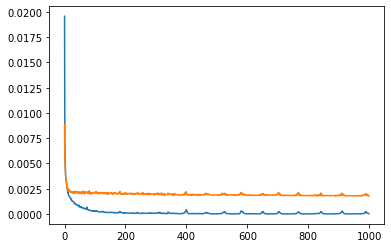

In [10]:
model = init_model()
history = model.fit(train_X, train_Y, 
                    epochs=1000, 
                    batch_size=20,
                    validation_data=(test_X, test_Y), 
                    verbose=2)

train_score = model.evaluate(train_X, train_Y, batch_size=20)
test_score = model.evaluate(test_X, test_Y, batch_size= 50)
print(train_score)
print(test_score)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

Test 0
True shape: [0.2 0.2 0.3 0.4 0.3 0.3]
Predicted shape: [[0.22393832 0.19892702 0.3096208  0.35105002 0.30258188 0.34191588]]



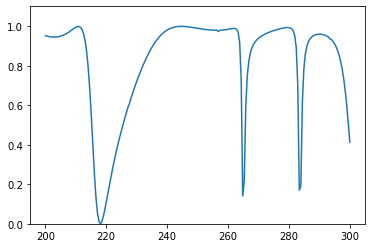

Test 1
True shape: [0.4       0.3       0.2370452 0.2       0.2       0.3      ]
Predicted shape: [[0.40134832 0.29707843 0.20395061 0.30986106 0.20724583 0.21303698]]



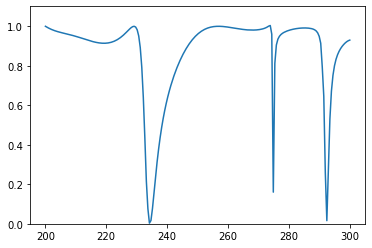

Test 2
True shape: [0.3 0.3 0.3 0.4 0.3 0.4]
Predicted shape: [[0.28785315 0.29969692 0.3078351  0.39196298 0.3053993  0.3893615 ]]



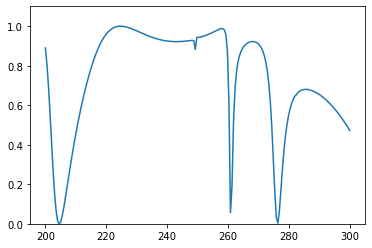

Test 3
True shape: [0.4        0.35084526 0.31945452 0.3        0.2        0.2       ]
Predicted shape: [[0.3769898  0.3722962  0.30469778 0.30099165 0.19440834 0.287828  ]]



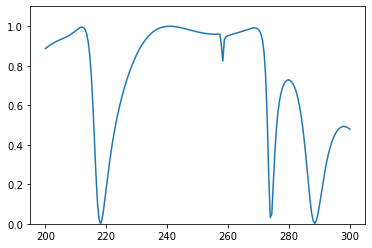

Test 4
True shape: [0.3       0.2963065 0.3       0.3       0.4       0.3      ]
Predicted shape: [[0.2947067  0.29308522 0.3010015  0.28868848 0.39579213 0.36385483]]



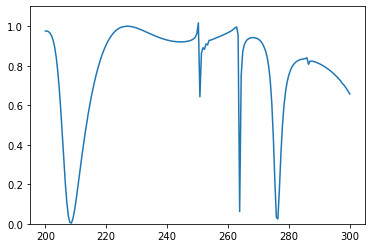

Test 5
True shape: [0.3      0.338636 0.4      0.3      0.2      0.1     ]
Predicted shape: [[0.31730723 0.3913097  0.34715515 0.30192134 0.2105813  0.11027607]]



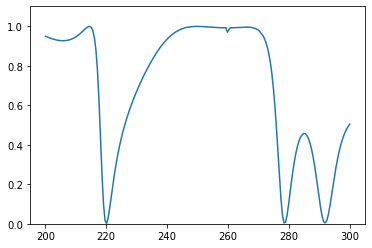

Test 6
True shape: [0.2       0.2370452 0.3       0.338636  0.4       0.4      ]
Predicted shape: [[0.21393025 0.2677756  0.30007178 0.31151623 0.3972033  0.41037017]]



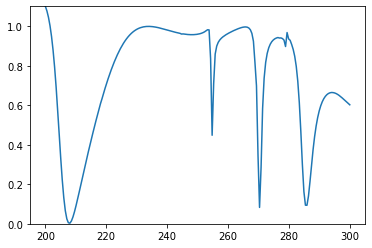

Test 7
True shape: [0.1 0.2 0.3 0.3 0.3 0.3]
Predicted shape: [[0.09786224 0.19645718 0.2970512  0.28892645 0.3019377  0.30597728]]



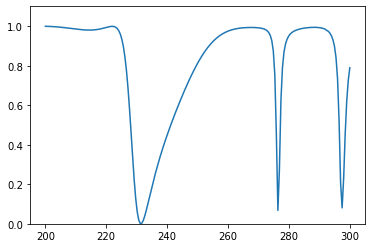

Test 8
True shape: [0.1      0.2      0.3      0.292613 0.292613 0.3     ]
Predicted shape: [[0.15971142 0.2455265  0.3103034  0.28548416 0.29061612 0.25346535]]



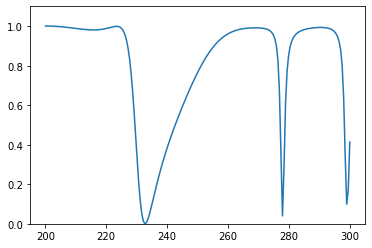

Test 9
True shape: [0.4      0.338636 0.3      0.3      0.4      0.5     ]
Predicted shape: [[0.33545864 0.29584104 0.36783224 0.4063509  0.3546044  0.39993128]]



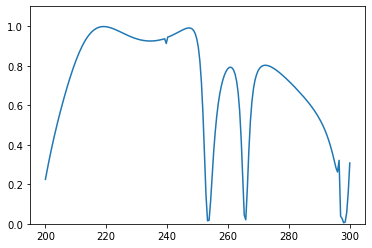

Test 10
True shape: [0.3        0.338636   0.4        0.4        0.5        0.49384417]
Predicted shape: [[0.3702075  0.36457923 0.40300873 0.40143242 0.45148912 0.49899578]]



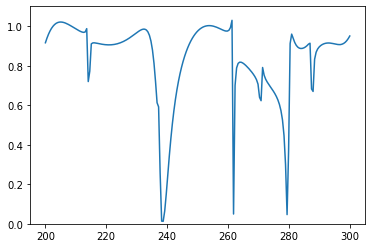

Test 11
True shape: [0.4       0.3       0.3       0.2963065 0.3       0.3      ]
Predicted shape: [[0.3979078  0.2969435  0.30232066 0.2957205  0.29772064 0.30097178]]



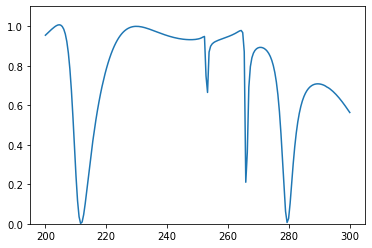

Test 12
True shape: [0.4        0.3        0.4        0.4        0.38516462 0.38042261]
Predicted shape: [[0.3134778  0.31828544 0.39894003 0.38048273 0.4231855  0.41256857]]



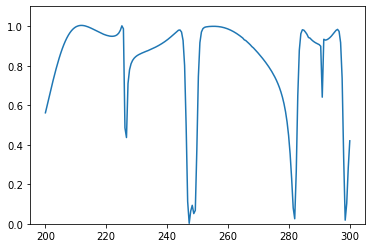

Test 13
True shape: [0.1      0.2      0.3      0.338636 0.4      0.3     ]
Predicted shape: [[0.09513932 0.18464589 0.28173572 0.38458923 0.3011595  0.4144287 ]]



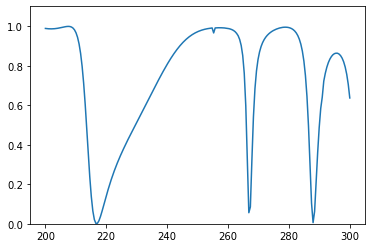

Test 14
True shape: [0.28531695 0.28887347 0.3        0.4        0.338636   0.3       ]
Predicted shape: [[0.3102833  0.3020802  0.31310302 0.33439282 0.385919   0.3369464 ]]



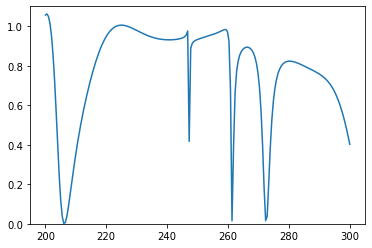

Test 15
True shape: [0.3       0.2963065 0.3       0.4       0.3       0.4      ]
Predicted shape: [[0.28946275 0.30226576 0.30362642 0.39777815 0.3031196  0.39704335]]



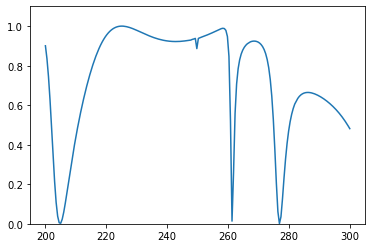

Test 16
True shape: [0.4 0.5 0.4 0.3 0.3 0.3]
Predicted shape: [[0.3987696  0.49961194 0.3970589  0.2992141  0.2985872  0.2986379 ]]



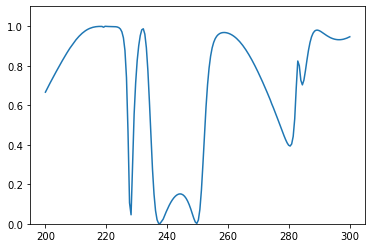

Test 17
True shape: [0.4        0.35084526 0.31945452 0.3        0.2        0.19753767]
Predicted shape: [[0.3672432  0.36263633 0.31913614 0.29996592 0.19887033 0.2301935 ]]



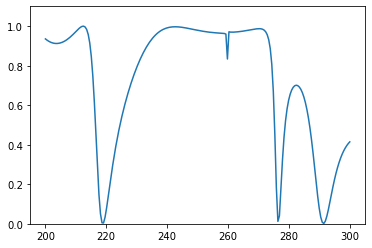

Test 18
True shape: [0.2 0.3 0.4 0.3 0.3 0.3]
Predicted shape: [[0.28688523 0.27381307 0.29683    0.42090017 0.26823282 0.22643891]]



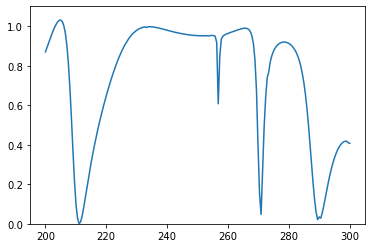

Test 19
True shape: [0.2 0.3 0.3 0.3 0.4 0.3]
Predicted shape: [[0.21692246 0.3154779  0.32088524 0.32456678 0.32134795 0.35140258]]



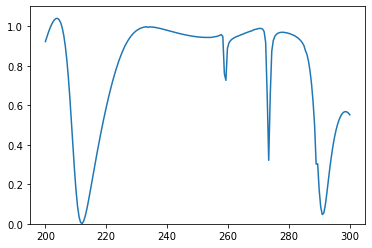

Test 20
True shape: [0.2       0.3       0.2963065 0.3       0.338636  0.4      ]
Predicted shape: [[0.20115536 0.30976763 0.3089364  0.30003917 0.33144847 0.40237918]]



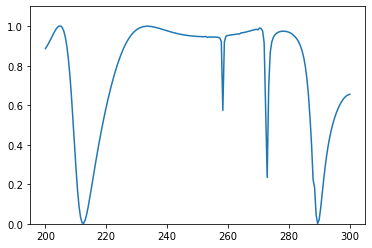

Test 21
True shape: [0.3 0.4 0.4 0.5 0.4 0.5]
Predicted shape: [[0.26941097 0.3941298  0.4255105  0.47673744 0.4584015  0.42976567]]



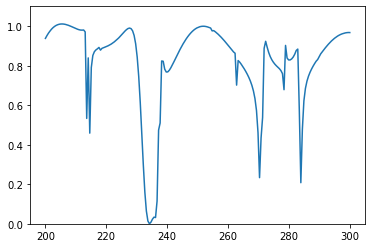

Test 22
True shape: [0.19753767 0.2        0.3        0.4        0.3        0.2963065 ]
Predicted shape: [[0.19827455 0.20008376 0.3012606  0.3910809  0.29879817 0.30440882]]



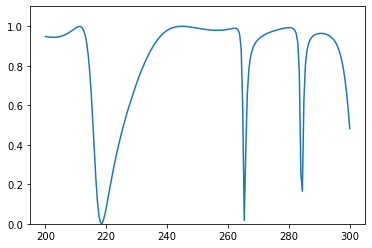

Test 23
True shape: [0.2 0.2 0.3 0.4 0.3 0.2]
Predicted shape: [[0.2340335  0.22796434 0.29536697 0.36174443 0.30491292 0.23472337]]



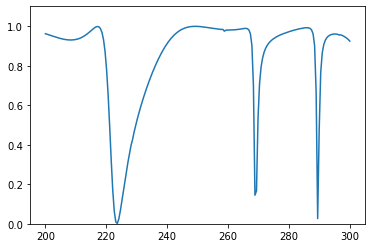

Test 24
True shape: [0.28531695 0.28887347 0.3        0.338636   0.4        0.5       ]
Predicted shape: [[0.28753558 0.32027864 0.33357948 0.35194176 0.3830761  0.41903302]]



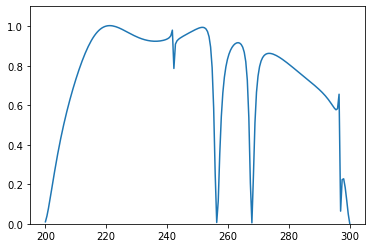

Test 25
True shape: [0.5 0.4 0.4 0.3 0.3 0.4]
Predicted shape: [[0.4464452  0.4467301  0.37024486 0.34118545 0.30313396 0.28683254]]



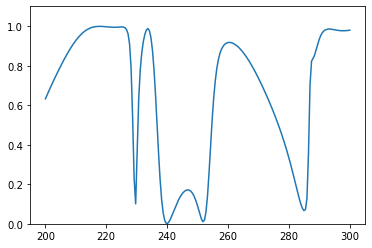

Test 26
True shape: [0.2 0.2 0.2 0.3 0.4 0.4]
Predicted shape: [[0.19748709 0.20168036 0.20239586 0.30016148 0.4028573  0.40171278]]



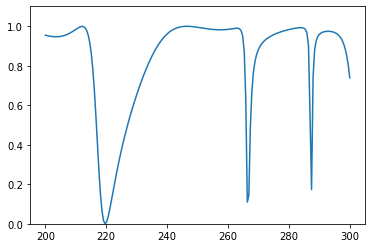

Test 27
True shape: [0.2963065 0.3       0.3       0.3       0.4       0.4      ]
Predicted shape: [[0.2939334  0.30078343 0.3011577  0.30093646 0.40406698 0.39870536]]



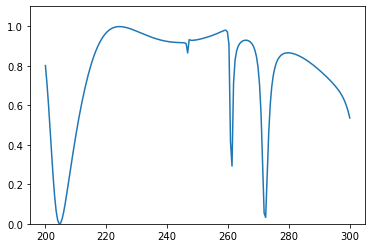

Test 28
True shape: [0.3       0.3       0.2963065 0.3       0.2370452 0.2      ]
Predicted shape: [[0.30318755 0.2392565  0.3007247  0.30269164 0.31076106 0.27549416]]



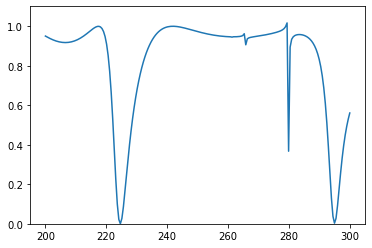

Test 29
True shape: [0.19753767 0.2        0.3        0.2963065  0.3        0.4       ]
Predicted shape: [[0.18964341 0.19756895 0.24290532 0.29723686 0.33917868 0.40962455]]



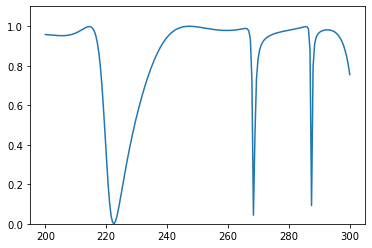

Test 30
True shape: [0.3        0.3        0.4        0.5        0.49384417 0.5       ]
Predicted shape: [[0.32493797 0.2972563  0.38968104 0.49891394 0.5018663  0.47725222]]



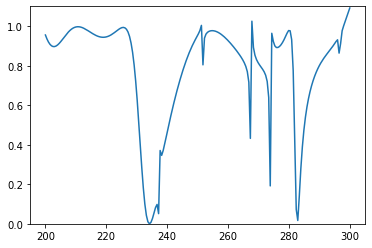

Test 31
True shape: [0.49384417 0.5        0.4        0.5        0.4        0.4       ]
Predicted shape: [[0.5007686  0.49485987 0.39467335 0.49620655 0.40328512 0.40555707]]



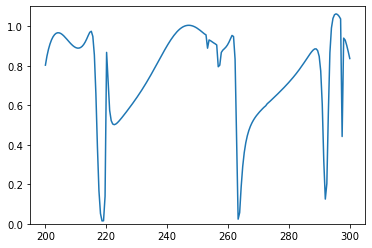

Test 32
True shape: [0.49384417 0.5        0.4389726  0.4        0.4        0.5       ]
Predicted shape: [[0.2540536  0.2568986  0.23261997 0.33769843 0.4111681  0.3896128 ]]



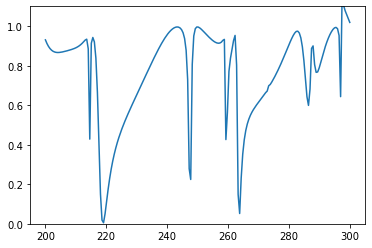

Test 33
True shape: [0.2963065  0.3        0.4        0.39015067 0.39015067 0.4       ]
Predicted shape: [[0.3161465  0.32021868 0.3491094  0.4100512  0.39442015 0.40852287]]



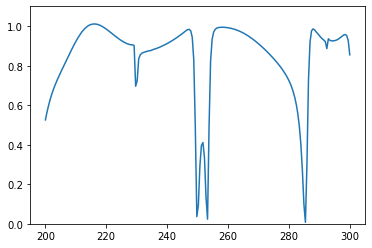

Test 34
True shape: [0.2963065 0.3       0.3       0.4       0.3       0.2963065]
Predicted shape: [[0.29805058 0.29733837 0.30159712 0.39303094 0.29956403 0.29813012]]



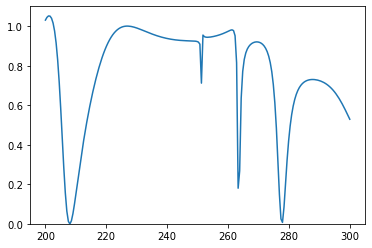

Test 35
True shape: [0.39507534 0.4        0.338636   0.3        0.2        0.1       ]
Predicted shape: [[0.33984852 0.3951788  0.3750186  0.29759014 0.20459053 0.12178357]]



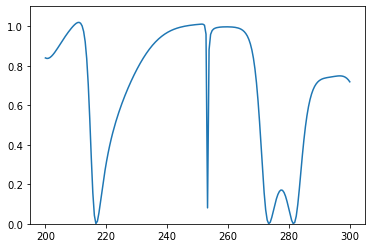

Test 36
True shape: [0.2        0.2370452  0.3        0.31945452 0.35084526 0.4       ]
Predicted shape: [[0.24625114 0.3126549  0.3145544  0.30189455 0.32570487 0.375753  ]]



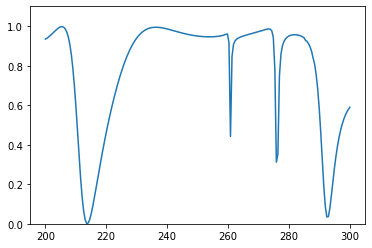

Test 37
True shape: [0.3        0.4        0.39507534 0.4        0.338636   0.3       ]
Predicted shape: [[0.30135143 0.4018288  0.3966434  0.40072525 0.34272647 0.30405676]]



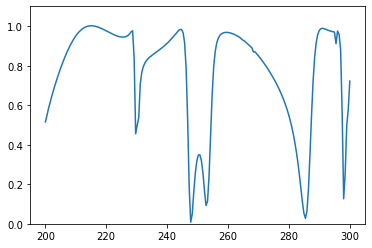

Test 38
True shape: [0.5       0.4       0.4       0.5       0.4389726 0.4      ]
Predicted shape: [[0.4479728  0.38248375 0.42285815 0.42200834 0.42518684 0.28332752]]



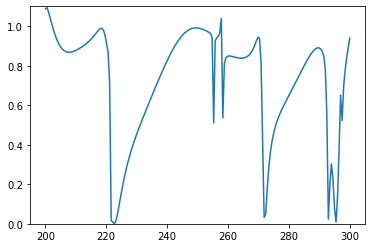

Test 39
True shape: [0.4      0.338636 0.3      0.3      0.3      0.2     ]
Predicted shape: [[0.38467196 0.30516684 0.3181244  0.28415307 0.2493198  0.23405024]]



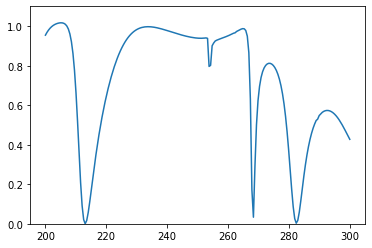

Test 40
True shape: [0.3 0.3 0.4 0.4 0.3 0.3]
Predicted shape: [[0.2974404  0.30280915 0.40228766 0.39463043 0.30113614 0.30057156]]



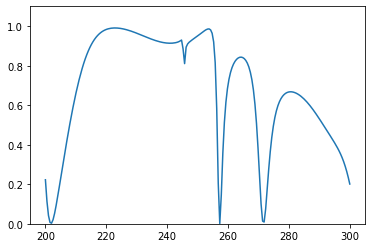

Test 41
True shape: [0.3 0.2 0.3 0.4 0.3 0.2]
Predicted shape: [[0.20988807 0.29408658 0.2443037  0.3243847  0.32860863 0.37989965]]



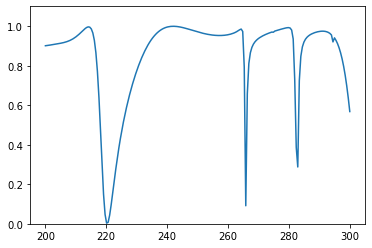

Test 42
True shape: [0.3      0.338636 0.4      0.3      0.4      0.5     ]
Predicted shape: [[0.30150747 0.40844816 0.31850058 0.31856328 0.40964264 0.49941298]]



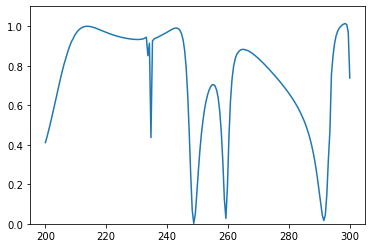

Test 43
True shape: [0.2963065 0.3       0.338636  0.4       0.3       0.2963065]
Predicted shape: [[0.29830867 0.2977547  0.3385242  0.40245676 0.299676   0.2965263 ]]



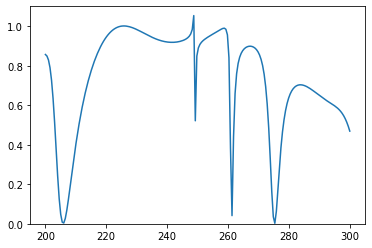

Test 44
True shape: [0.4 0.3 0.3 0.3 0.4 0.4]
Predicted shape: [[0.4065342  0.30070567 0.30581868 0.3005523  0.39229488 0.40097564]]



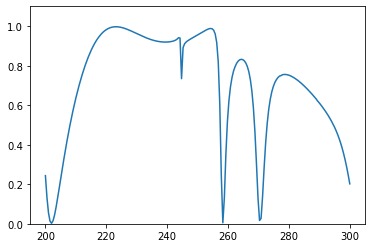

Test 45
True shape: [0.2963065 0.3       0.4       0.3       0.4       0.3      ]
Predicted shape: [[0.37240076 0.29259184 0.3110479  0.36716515 0.39292008 0.291117  ]]



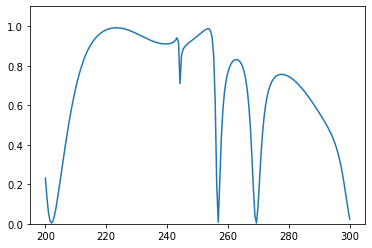

Test 46
True shape: [0.3       0.4       0.3       0.4       0.3       0.2963065]
Predicted shape: [[0.3084694  0.3790202  0.31969327 0.3782399  0.30188674 0.31372947]]



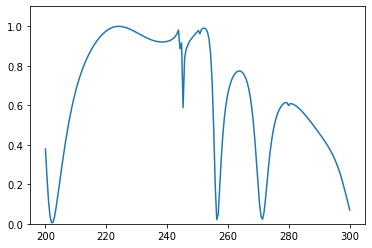

Test 47
True shape: [0.3        0.3        0.2963065  0.3        0.4        0.39507534]
Predicted shape: [[0.29920515 0.29482436 0.29916507 0.30097938 0.40052545 0.40011767]]



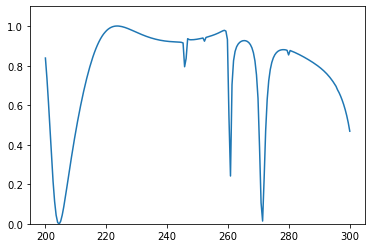

Test 48
True shape: [0.4 0.5 0.4 0.4 0.5 0.5]
Predicted shape: [[0.42835978 0.4057909  0.42040572 0.44163442 0.43317586 0.43691394]]



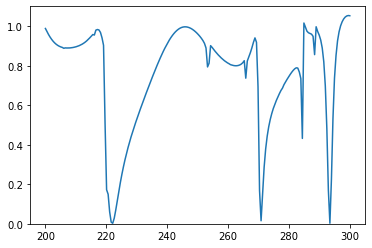

Test 49
True shape: [0.4        0.3        0.4        0.4389726  0.5        0.49384417]
Predicted shape: [[0.29613543 0.35070568 0.39973608 0.42386356 0.48705038 0.5063287 ]]



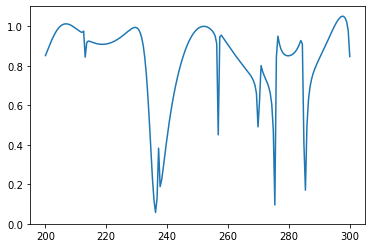

Test 50
True shape: [0.39507534 0.4        0.4        0.4        0.39507534 0.4       ]
Predicted shape: [[0.37780973 0.4054046  0.40114444 0.39470947 0.4073637  0.41512775]]



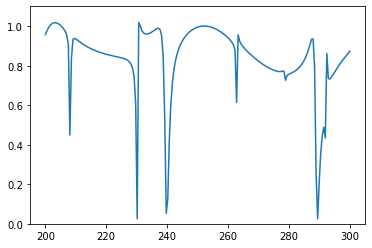

Test 51
True shape: [0.28531695 0.28887347 0.3        0.4        0.4        0.3       ]
Predicted shape: [[0.26891962 0.29795498 0.33181727 0.40268382 0.38147494 0.39301255]]



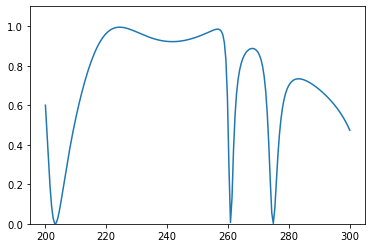

Test 52
True shape: [0.4        0.3        0.28887347 0.28531695 0.28887347 0.3       ]
Predicted shape: [[0.3719417  0.29204977 0.28130388 0.33067498 0.29557177 0.24182437]]



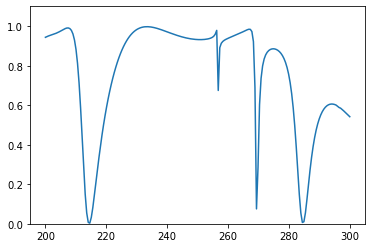

Test 53
True shape: [0.35640261 0.36084521 0.37474388 0.4        0.5        0.49384417]
Predicted shape: [[0.3231693  0.39698952 0.40316284 0.4229126  0.49763882 0.47983906]]



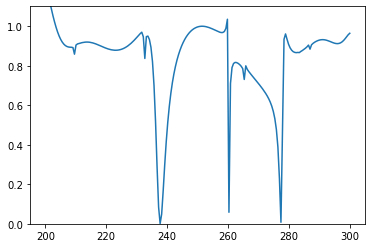

Test 54
True shape: [0.2963065  0.3        0.4        0.3        0.28887347 0.28531695]
Predicted shape: [[0.3122747  0.30067194 0.38889098 0.3015886  0.29244965 0.31551436]]



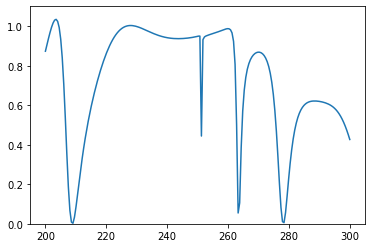

Test 55
True shape: [0.2 0.2 0.3 0.3 0.3 0.4]
Predicted shape: [[0.20238164 0.19475251 0.24272883 0.29328844 0.3346668  0.412675  ]]



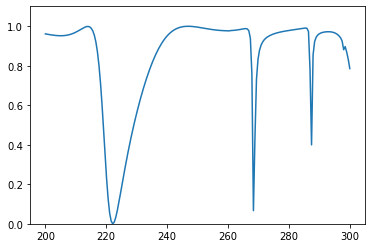

Test 56
True shape: [0.2        0.2370452  0.3        0.4        0.4        0.39507534]
Predicted shape: [[0.20716813 0.22576594 0.29621387 0.40147942 0.40036693 0.40296102]]



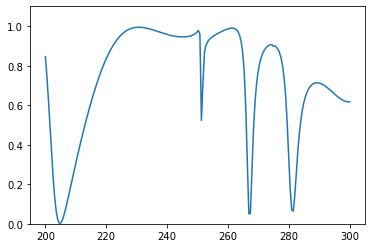

Test 57
True shape: [0.4       0.3       0.2963065 0.3       0.3       0.3      ]
Predicted shape: [[0.39827657 0.29776824 0.3021889  0.29451895 0.29808298 0.3011011 ]]



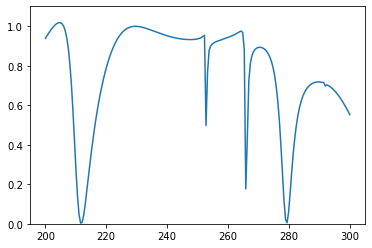

Test 58
True shape: [0.5      0.4      0.4      0.338636 0.3      0.4     ]
Predicted shape: [[0.4792969  0.39259738 0.37825632 0.314856   0.36595786 0.42139322]]



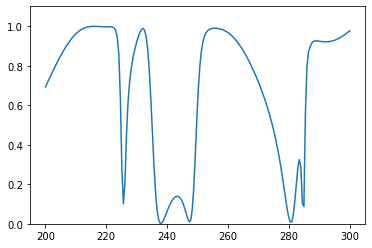

Test 59
True shape: [0.3        0.2        0.3        0.3        0.4        0.39507534]
Predicted shape: [[0.2991434  0.19962958 0.3019129  0.30247748 0.394024   0.39813974]]



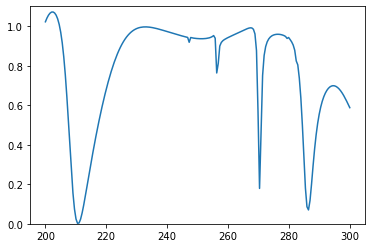

Test 60
True shape: [0.1        0.2        0.2370452  0.3        0.4        0.39507534]
Predicted shape: [[0.10166559 0.19353807 0.30453873 0.32277125 0.3647624  0.3338174 ]]



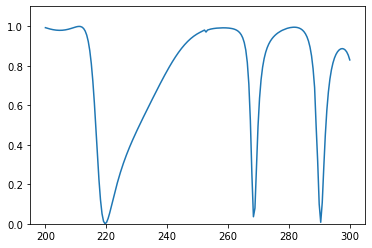

Test 61
True shape: [0.4        0.39507534 0.4        0.5        0.4        0.5       ]
Predicted shape: [[0.36605626 0.39795446 0.42411828 0.47372013 0.46571356 0.4475441 ]]



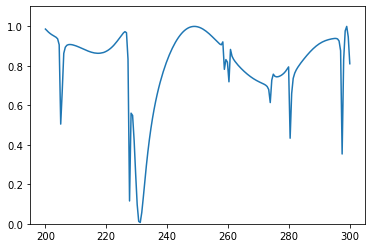

Test 62
True shape: [0.2963065 0.3       0.4       0.5       0.5       0.5      ]
Predicted shape: [[0.32233852 0.29064098 0.3969983  0.49977806 0.5052112  0.49296704]]



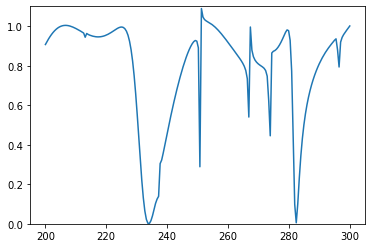

Test 63
True shape: [0.3        0.338636   0.4        0.5        0.49384417 0.5       ]
Predicted shape: [[0.31547153 0.33827186 0.4028796  0.48940843 0.4896219  0.49491444]]



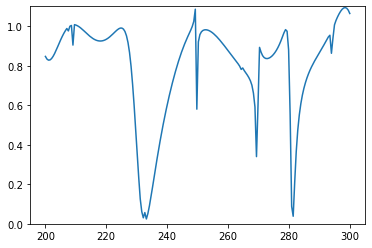

Test 64
True shape: [0.3       0.3       0.2963065 0.3       0.338636  0.4      ]
Predicted shape: [[0.27962422 0.291055   0.29255003 0.3030966  0.33421165 0.40121457]]



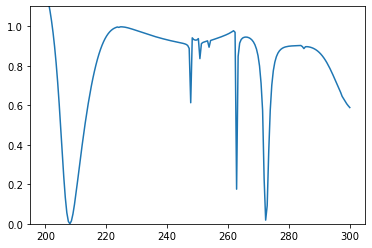

Test 65
True shape: [0.4       0.3       0.2370452 0.2       0.3       0.4      ]
Predicted shape: [[0.22809225 0.26147372 0.31458268 0.31558496 0.29322252 0.37967736]]



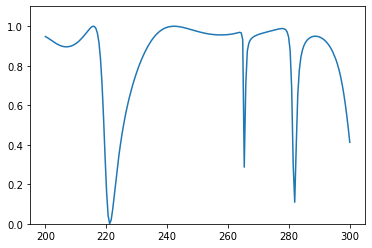

Test 66
True shape: [0.1902113  0.19258231 0.2        0.3        0.4        0.39507534]
Predicted shape: [[0.22590044 0.1766907  0.23568425 0.3090769  0.37166026 0.40384766]]



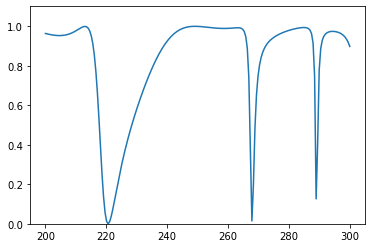

Test 67
True shape: [0.3        0.338636   0.4        0.5        0.5        0.49384417]
Predicted shape: [[0.32918352 0.33317548 0.4064626  0.49032235 0.49373156 0.4992778 ]]



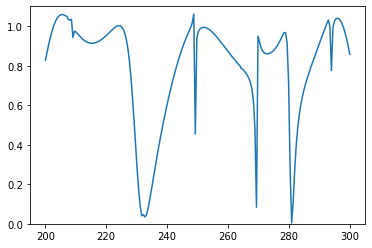

Test 68
True shape: [0.5        0.4        0.4        0.4        0.5        0.49384417]
Predicted shape: [[0.49301028 0.40991813 0.39650142 0.4012064  0.48902798 0.49983114]]



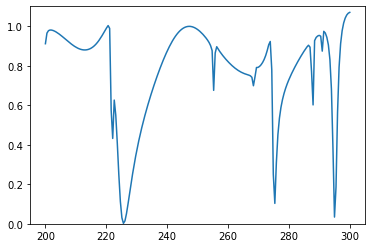

Test 69
True shape: [0.2963065 0.3       0.4       0.3       0.3       0.3      ]
Predicted shape: [[0.29251677 0.29324844 0.39980632 0.2882489  0.30146655 0.295697  ]]



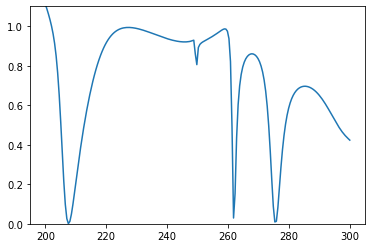

Test 70
True shape: [0.2       0.2370452 0.3       0.4       0.4       0.4      ]
Predicted shape: [[0.2012271  0.23942313 0.30355465 0.39376992 0.40193298 0.41318437]]



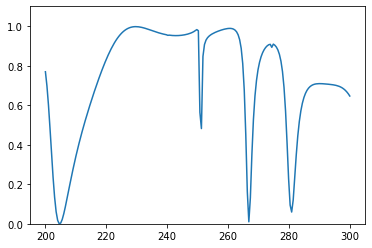

Test 71
True shape: [0.39507534 0.4        0.4        0.39507534 0.4        0.39507534]
Predicted shape: [[0.40240538 0.4019952  0.39446324 0.390944   0.3975853  0.3898866 ]]



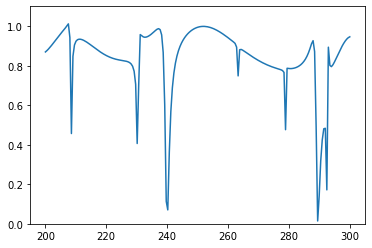

Test 72
True shape: [0.3 0.4 0.4 0.4 0.5 0.5]
Predicted shape: [[0.29784426 0.3965714  0.40190652 0.41488385 0.49750176 0.49395496]]



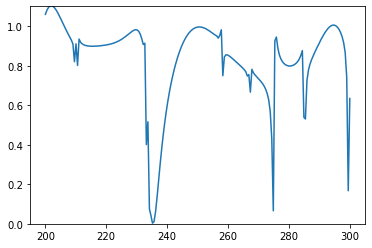

Test 73
True shape: [0.2963065 0.3       0.2963065 0.3       0.2370452 0.2      ]
Predicted shape: [[0.31905097 0.23217854 0.30073485 0.2869724  0.31563908 0.24134085]]



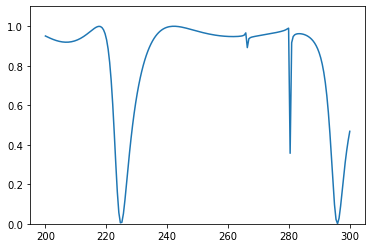

Test 74
True shape: [0.39507534 0.4        0.3        0.4        0.4        0.5       ]
Predicted shape: [[0.314994   0.33014205 0.39980572 0.39111003 0.4263682  0.47021103]]



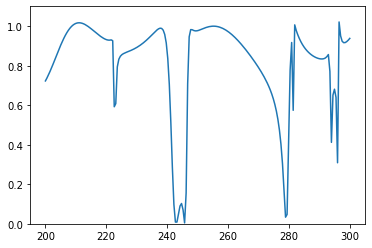

Test 75
True shape: [0.5 0.4 0.4 0.4 0.3 0.2]
Predicted shape: [[0.5078715  0.39864352 0.3899799  0.39379227 0.30682054 0.21002974]]



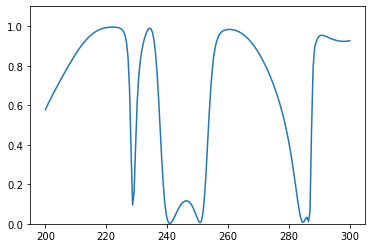

Test 76
True shape: [0.2 0.3 0.3 0.4 0.3 0.3]
Predicted shape: [[0.19397643 0.29588854 0.2959699  0.39117783 0.30193013 0.30151275]]



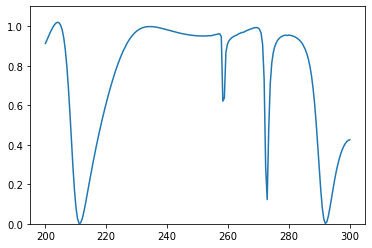

Test 77
True shape: [0.3      0.3      0.3      0.338636 0.4      0.3     ]
Predicted shape: [[0.3026991  0.30291468 0.30909425 0.30692655 0.39670363 0.3746577 ]]



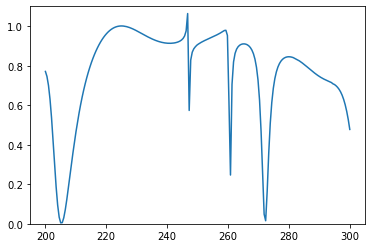

Test 78
True shape: [0.5       0.4       0.3       0.2370452 0.2       0.1      ]
Predicted shape: [[0.47410887 0.40009177 0.29643157 0.19222066 0.14915513 0.09260879]]



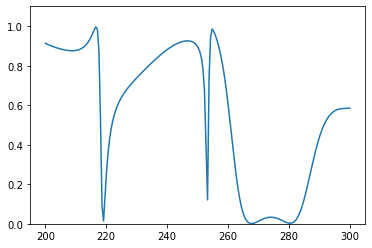

Test 79
True shape: [0.3        0.2        0.3        0.4        0.4        0.39507534]
Predicted shape: [[0.30061585 0.1994113  0.3011596  0.3937261  0.40201858 0.4076506 ]]



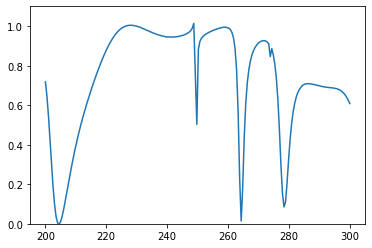

Test 80
True shape: [0.3 0.4 0.5 0.4 0.4 0.3]
Predicted shape: [[0.3576985  0.42319387 0.4490251  0.46369463 0.3497906  0.3550159 ]]



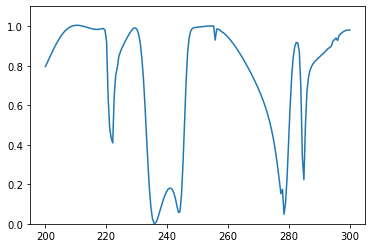

Test 81
True shape: [0.3        0.4        0.5        0.5        0.4        0.39507534]
Predicted shape: [[0.2860778  0.37338036 0.52878374 0.43732446 0.4450016  0.50507015]]



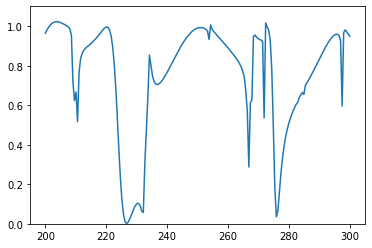

Test 82
True shape: [0.3        0.338636   0.4        0.5        0.48145578 0.47552826]
Predicted shape: [[0.34192353 0.34578303 0.40156043 0.49235192 0.4878113  0.44856995]]



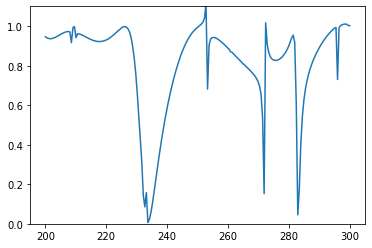

Test 83
True shape: [0.3 0.3 0.2 0.2 0.3 0.4]
Predicted shape: [[0.26398575 0.2506445  0.3427381  0.33482355 0.2998494  0.3392775 ]]



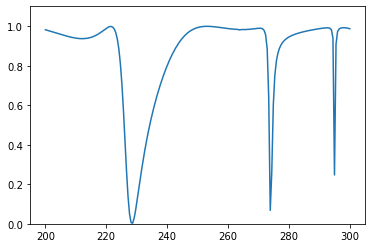

Test 84
True shape: [0.4045085  0.40955075 0.4253254  0.4539905  0.5        0.49384417]
Predicted shape: [[0.4008564  0.3974448  0.41892016 0.451531   0.49374774 0.47080582]]



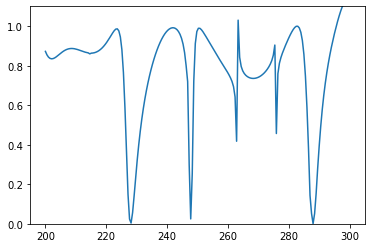

Test 85
True shape: [0.2       0.3       0.4       0.3       0.2963065 0.3      ]
Predicted shape: [[0.27665895 0.251917   0.29783744 0.43466803 0.24098761 0.25790358]]



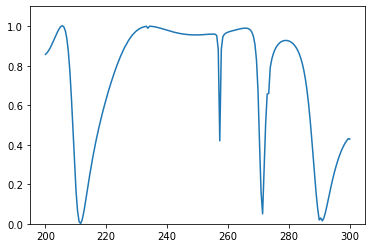

Test 86
True shape: [0.3       0.3       0.3       0.4       0.3       0.2963065]
Predicted shape: [[0.29760006 0.29961944 0.30125564 0.3974423  0.30047482 0.30021605]]



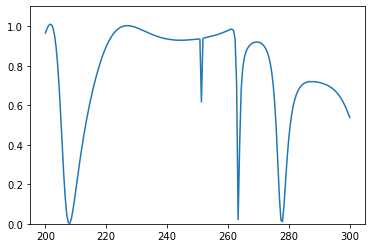

Test 87
True shape: [0.4        0.40597245 0.42269179 0.45246718 0.5        0.49384417]
Predicted shape: [[0.40277085 0.39761472 0.42130223 0.44940105 0.4707444  0.47548127]]



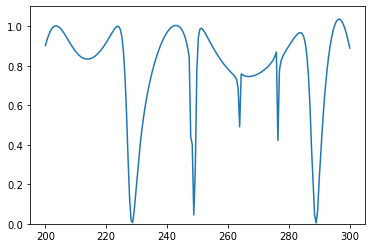

Test 88
True shape: [0.5        0.4        0.3        0.2        0.13169178 0.1       ]
Predicted shape: [[0.4938253  0.40014896 0.30075145 0.18922168 0.09363803 0.17868197]]



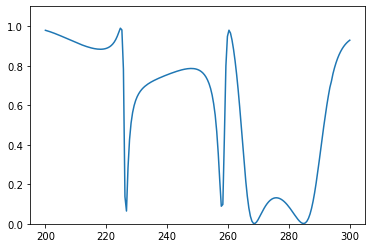

Test 89
True shape: [0.4      0.338636 0.3      0.3      0.2      0.1     ]
Predicted shape: [[0.3018486  0.38786277 0.29259795 0.26713496 0.20331694 0.11583334]]



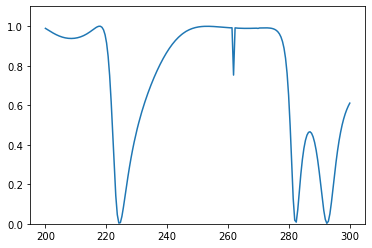

Test 90
True shape: [0.1 0.2 0.2 0.3 0.4 0.5]
Predicted shape: [[0.12556353 0.21402168 0.275295   0.34141296 0.35829535 0.46756   ]]



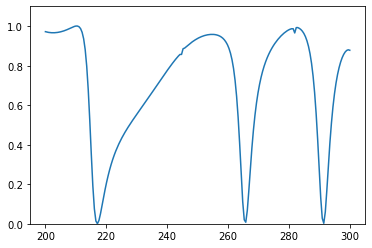

Test 91
True shape: [0.4        0.4        0.3        0.4        0.38516462 0.38042261]
Predicted shape: [[0.3415971  0.41431844 0.38794813 0.38255644 0.35981995 0.32608998]]



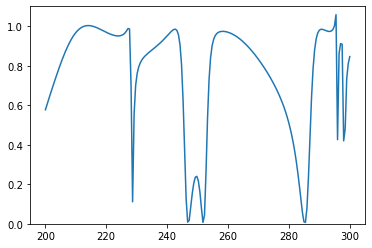

Test 92
True shape: [0.2963065 0.3       0.4       0.3       0.3       0.2      ]
Predicted shape: [[0.27962822 0.35241532 0.31197447 0.34854755 0.2549384  0.22905913]]



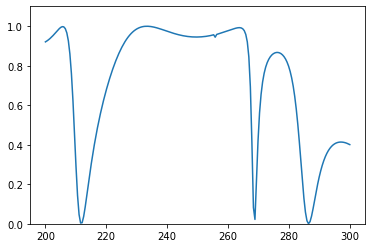

Test 93
True shape: [0.2 0.1 0.2 0.3 0.4 0.4]
Predicted shape: [[0.1933533  0.10041675 0.20330912 0.2933125  0.40532815 0.40094766]]



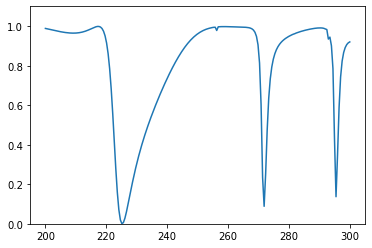

Test 94
True shape: [0.3 0.3 0.3 0.2 0.3 0.4]
Predicted shape: [[0.19808915 0.22960928 0.26091737 0.31307346 0.32366613 0.37098554]]



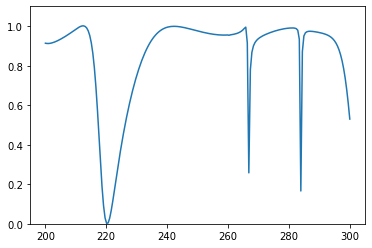

Test 95
True shape: [0.1       0.2       0.2370452 0.3       0.4       0.4      ]
Predicted shape: [[0.10185507 0.19551572 0.303635   0.32269692 0.36319894 0.3450212 ]]



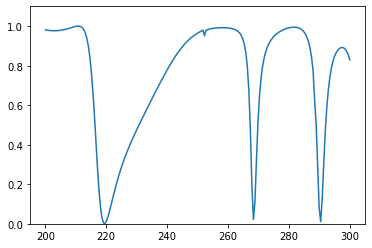

Test 96
True shape: [0.4 0.5 0.4 0.3 0.4 0.5]
Predicted shape: [[0.4853103  0.42928535 0.47109047 0.41147092 0.34811252 0.41366622]]



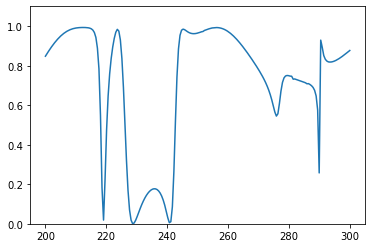

Test 97
True shape: [0.4      0.338636 0.3      0.338636 0.4      0.5     ]
Predicted shape: [[0.30989265 0.35337895 0.3344064  0.41190994 0.4026182  0.4230922 ]]



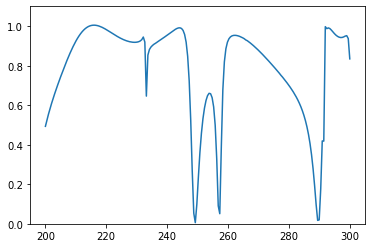

Test 98
True shape: [0.28531695 0.28887347 0.3        0.338636   0.4        0.3       ]
Predicted shape: [[0.30830407 0.3143717  0.3104484  0.311534   0.41112968 0.34408653]]



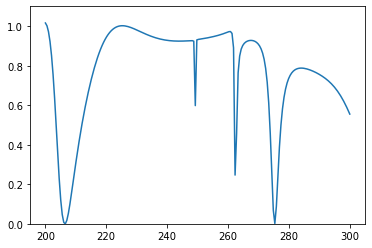

Test 99
True shape: [0.5 0.4 0.3 0.3 0.4 0.4]
Predicted shape: [[0.48602396 0.4048704  0.3006994  0.31426257 0.4084634  0.35467306]]



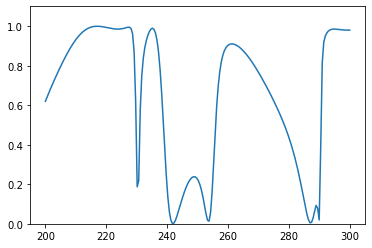

Test 100
True shape: [0.3      0.4      0.3      0.338636 0.4      0.3     ]
Predicted shape: [[0.40428525 0.3214804  0.3208056  0.39725316 0.30281582 0.40436333]]



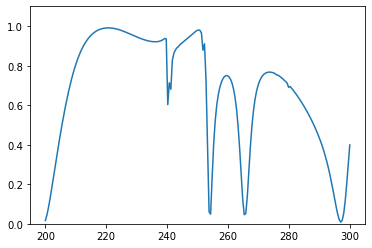

Test 101
True shape: [0.5       0.4389726 0.4       0.3       0.2       0.3      ]
Predicted shape: [[0.4749742  0.4347903  0.38830504 0.3127557  0.25407007 0.24219428]]



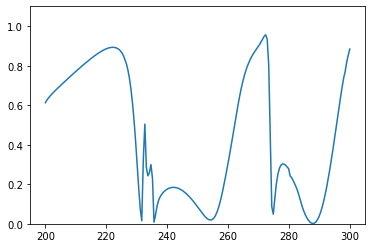

Test 102
True shape: [0.39507534 0.4        0.338636   0.3        0.4        0.5       ]
Predicted shape: [[0.31912324 0.36623845 0.4066089  0.3755742  0.38926223 0.44861045]]



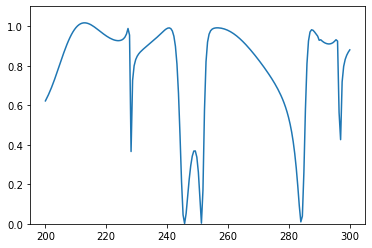

Test 103
True shape: [0.4        0.4        0.39507534 0.4        0.38516462 0.38042261]
Predicted shape: [[0.39324456 0.39981923 0.39291638 0.3921245  0.39632007 0.3943488 ]]



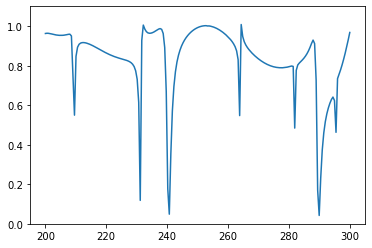

Test 104
True shape: [0.3 0.3 0.3 0.3 0.4 0.4]
Predicted shape: [[0.2974692  0.29964846 0.2995444  0.29960144 0.4017879  0.3994699 ]]



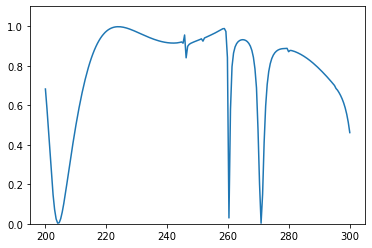

Test 105
True shape: [0.2963065 0.3       0.292613  0.292613  0.3       0.4      ]
Predicted shape: [[0.28781778 0.29180455 0.29717678 0.29696247 0.3034178  0.40209025]]



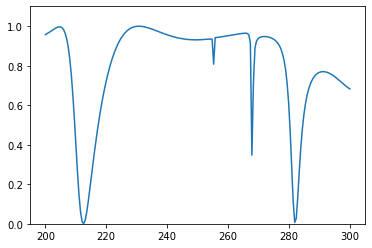

Test 106
True shape: [0.3      0.3      0.338636 0.4      0.3      0.2     ]
Predicted shape: [[0.28692186 0.28748867 0.3348556  0.3981169  0.29218873 0.19493829]]



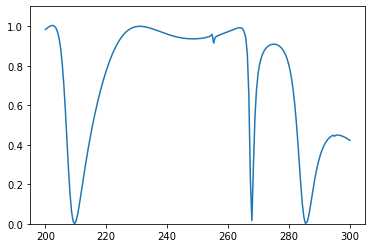

In [11]:
predicted = []
x = np.genfromtxt('meep_code/data/SP_xaxis.txt')
for i in range(len(test_X)):
    print('Test '+str(i))
    print('True shape: ' + str(test_Y[i]))
    print('Predicted shape: ' + str(model.predict(np.reshape(test_X[i], (1, 200))))+'\n')
    plt.ylim(0, 1.1)
    plt.plot(x, np.subtract(test_X[i], -0.5))
    plt.show()
    predicted.append(*model.predict(np.reshape(test_X[i], (1, 200))))